In [46]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

### Initial state initialyzing

In [47]:
n, l = 3, 4 # количество видов узлов и возможных взаимодействий между ними
alpha = np.array([100, 4, 0]) # уязвимые, заражённые, невосприимчивые, лекарство
N = sum(alpha)
Vs = N // 2 - 1 # скорость сканирования ip4 адресов вирусом [узел/сек]
lmb = 0.02 # интенсивность потока заражения [скорость * кол-во узлов / размер адресного пространства]
imm = lmb * 5 # интенсивность потока лечения заражения
a = lmb * 100 # интенсивность потока добавления новых узлов в компьютерную сеть
eps = np.array([[1, 1, 0], #заражение
                [0, 1, 0], # лечение заражённого
                [1, 0, 0], # иммунизация уязвимого
                [0, 0, 0]]) # добавление нового узла
phi = np.array([lmb*alpha[0]*alpha[1], imm*alpha[1], imm*alpha[0], a])
p_gamma = np.array([[0, 2, 0], # два заражённых
                    [0, 0, 1], # новый неуязвимый
                    [0, 0, 1], # новый неуязвимый
                    [1, 0, 0]]) # новый уязвимый

### Process

In [48]:
def inverse_exp(random_, coef):
    '''возвращает значение случайной величины,
    распределённой по экспоненциальному закону,
    соответствующему простейшему Пуассоновскому потоку'''
    if coef == 0:
        return np.finfo(np.float32).max
    return -1/coef * math.log(1 - random_)

tau = np.array([0 for _ in range(l)], dtype=np.float32) # время следующего события i
for i in range(l):
    tau[i] = inverse_exp(random.random(), phi[i])

def update_tau(tau, ):
    ''' Возвращает матрицу с временами событий на следующем шаге и ближайшее событие
    :param tau: array of trigger times, generated on the previous step
    :return: times array on the next step, next event, time of next event'''
    min_ = np.finfo(np.float32).max
    idx_min = 0

    for k in range(len(tau)):
        if tau[k] == np.finfo(np.float32).max and phi[k] != 0:
            tau[k] = inverse_exp(random.random(), phi[k])
        if tau[k] < min_:
            min_ = tau[k]
            idx_min = k
    tau -= min_
    return tau, idx_min, min_

def update_phi(alpha):
    phi = np.array([lmb*alpha[0]*alpha[1], imm*alpha[1], imm*alpha[0], a])
    phi[~np.all(eps <= alpha, axis=1)] = 0
    return phi

def taking_action(alpha, next_event):
    alpha += -eps[next_event] + p_gamma[next_event]
    phi = update_phi(alpha)
    return alpha, phi


### Running K steps

In [49]:
k = 200
particles_history = np.empty((k + 1, n))
times = np.empty(k + 1)
particles_history[0, :] = alpha
times[0] = 0
print(alpha)
for i in range(1, k + 1):
    tau, next_event, delta_time = update_tau(tau)
    alpha, phi = taking_action(alpha, next_event)
    tau[next_event] = inverse_exp(random.random(), phi[next_event])
    particles_history[i, :] = alpha
    times[i] = delta_time + times[i - 1]
    print(f"after {i} step:")
    print("tau:", tau, "\nphi:", phi, "\nalpha:", alpha, "\nevent:", next_event)


[100   4   0]
after 1 step:
tau: [0.03255166 0.224677   0.06425855 0.2499678 ] 
phi: [7.92 0.4  9.9  2.  ] 
alpha: [99  4  1] 
event: 2
after 2 step:
tau: [0.18331085 0.19212534 0.03170688 0.21741614] 
phi: [9.8 0.5 9.8 2. ] 
alpha: [98  5  1] 
event: 0
after 3 step:
tau: [0.15160397 0.16041845 0.11920684 0.18570925] 
phi: [9.7 0.5 9.7 2. ] 
alpha: [97  5  2] 
event: 2
after 4 step:
tau: [0.03239713 0.04121161 0.07497187 0.06650241] 
phi: [9.6 0.5 9.6 2. ] 
alpha: [96  5  3] 
event: 2
after 5 step:
tau: [0.05765782 0.00881448 0.04257474 0.03410529] 
phi: [11.4  0.6  9.5  2. ] 
alpha: [95  6  3] 
event: 0
after 6 step:
tau: [0.04884334 2.4628766  0.03376026 0.0252908 ] 
phi: [9.5 0.5 9.5 2. ] 
alpha: [95  5  4] 
event: 1
after 7 step:
tau: [0.02355253 2.4375858  0.00846945 0.18597224] 
phi: [9.6 0.5 9.6 2. ] 
alpha: [96  5  4] 
event: 3
after 8 step:
tau: [0.01508308 2.4291165  0.37581694 0.17750278] 
phi: [9.5 0.5 9.5 2. ] 
alpha: [95  5  5] 
event: 2
after 9 step:
tau: [0.04374492 2.4

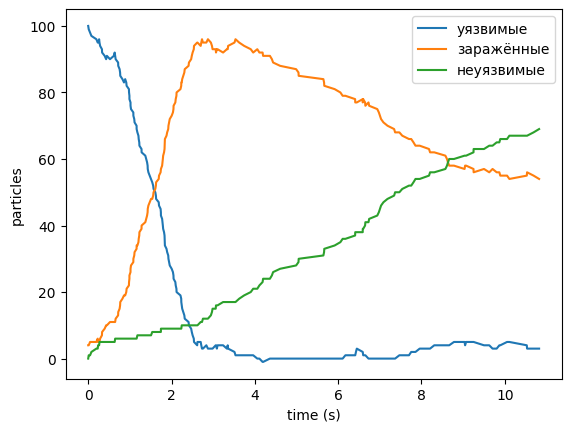

In [50]:
states = ["уязвимые", "заражённые", "неуязвимые"]
def plot_particles_history(particles_history, times):
    for i in range(n):
        plt.plot(times, particles_history[:, i], label=f"{states[i]}")
    plt.xlabel("time (s)")
    plt.ylabel("particles")
    plt.legend()
    plt.show()

plot_particles_history(particles_history, times)

### Obtaining 40 trajectories with 200 steps

In [51]:
# Фактически в общем случае получится 40 * 200 уникальных значений времени. Значит придётся
# интерполировать функции s(t), i(t), r(t) на значения времени из других траекторий, что создаст
# суммарно 40 * 200 * 3 значений в массиве состояний
k = 400
trj = 500
particles_history = np.empty((trj, k + 1, n))
times = np.empty((trj, k + 1))
particles_history[:, 0, :] = np.array([100, 4, 0])
times[:, 0] = 0

for j in range(trj):
    alpha = np.array([100, 4, 0])
    tau = np.array([0 for _ in range(l)], dtype=np.float32) # время следующего события i
    for i in range(l):
        tau[i] = inverse_exp(random.random(), phi[i])

    phi = np.array([lmb*alpha[0]*alpha[1], imm*alpha[1], imm*alpha[0], a])

    for i in range(1, k + 1):
        tau, next_event, delta_time = update_tau(tau)
        alpha, phi = taking_action(alpha, next_event)
        tau[next_event] = inverse_exp(random.random(), phi[next_event])
        particles_history[j, i, :] = alpha
        times[j, i] = delta_time + times[j, i - 1]
        if j == 0 or j == 1 or j == 2:
            print(f"after {i} step:")
            print("tau:", tau, "\nphi:", phi, "\nalpha:", alpha, "\nevent:", next_event)

after 1 step:
tau: [0.7493713  0.14795125 0.4985405  0.42424121] 
phi: [ 8.08  0.4  10.1   2.  ] 
alpha: [101   4   0] 
event: 3
after 2 step:
tau: [0.60142004 0.26453048 0.35058925 0.27628997] 
phi: [ 6.06  0.3  10.1   2.  ] 
alpha: [101   3   1] 
event: 1
after 3 step:
tau: [0.33688956 5.0881906  0.08605877 0.01175949] 
phi: [ 4.04  0.2  10.1   2.  ] 
alpha: [101   2   2] 
event: 1
after 4 step:
tau: [0.32513008 5.0764313  0.07429928 0.32328212] 
phi: [ 4.08  0.2  10.2   2.  ] 
alpha: [102   2   2] 
event: 3
after 5 step:
tau: [0.2508308  5.002132   0.19277987 0.24898285] 
phi: [ 4.04  0.2  10.1   2.  ] 
alpha: [101   2   3] 
event: 2
after 6 step:
tau: [0.05805093 4.809352   0.02461566 0.05620298] 
phi: [ 4.   0.2 10.   2. ] 
alpha: [100   2   4] 
event: 2
after 7 step:
tau: [0.03343527 4.784736   0.04221808 0.03158732] 
phi: [3.96 0.2  9.9  2.  ] 
alpha: [99  2  5] 
event: 2
after 8 step:
tau: [1.8479526e-03 4.7531490e+00 1.0630764e-02 5.7530618e-01] 
phi: [ 4.   0.2 10.   2. ] 
al

### Obtaining mean of trajectories

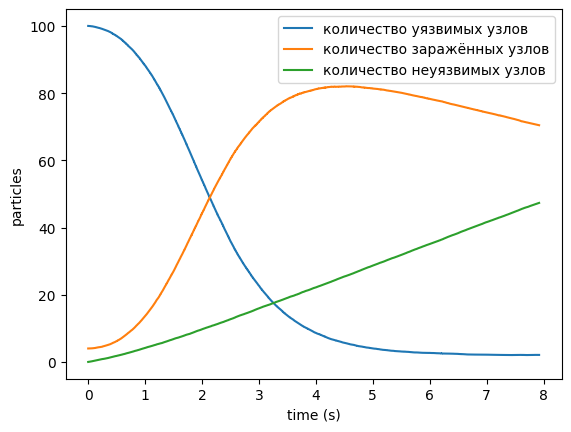

In [52]:
# Сложность алгоритма по времени O(trj^2 * (k - 2)) * O(np.mean)
# по памяти O(trj * (k - 2) * n); n - количество разных видов частиц (узлов)
indices = np.ones(trj, dtype=int)
cum_indices = np.zeros(trj, dtype=int)
merged = [np.array([100, 4, 0])]
total_times = [0]

for i in range(trj * (k - 2)):
    idx_min = np.argmin(times[np.arange(trj), indices])
    cum_indices[idx_min] = min(cum_indices[idx_min] + 1, 200)
    indices[idx_min] = min(indices[idx_min] + 1, 200)

    merged.append(np.mean(particles_history[np.arange(trj), cum_indices, :], axis=0))
    total_times.append(times[idx_min, cum_indices[idx_min]])

plt.plot(total_times, merged, label=["количество уязвимых узлов", "количество заражённых узлов", "количество неуязвимых узлов"])
plt.xlabel("time (s)")
plt.ylabel("particles")
plt.legend()
plt.show()

In [53]:
print(particles_history[[1, 2, 3], :4, :])

[[[100.   4.   0.]
  [101.   4.   0.]
  [102.   4.   0.]
  [103.   4.   0.]]

 [[100.   4.   0.]
  [ 99.   5.   0.]
  [ 98.   6.   0.]
  [ 97.   7.   0.]]

 [[100.   4.   0.]
  [ 99.   4.   1.]
  [100.   4.   1.]
  [ 99.   4.   2.]]]
